In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", 120)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")


In [2]:
# ---------- Load ----------
def load_retail_csv(path: str) -> pd.DataFrame:
    # Online Retail often needs latin-1 to avoid decode issues
    return pd.read_csv(path, encoding="latin-1")

# ---------- Basic schema coercion ----------
def coerce_schema(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    # Expected columns (Online Retail):
    # InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country
    if "InvoiceDate" in out.columns:
        out["InvoiceDate"] = pd.to_datetime(out["InvoiceDate"], errors="coerce")
    for col in ["Quantity", "UnitPrice", "CustomerID"]:
        if col in out.columns:
            out[col] = pd.to_numeric(out[col], errors="coerce")
    # Standardize text a bit
    if "Description" in out.columns:
        out["Description"] = (
            out["Description"]
            .astype(str)
            .str.strip()
            .str.replace(r"\s+", " ", regex=True)
        )
    # Build Revenue if possible
    if set(["Quantity","UnitPrice"]).issubset(out.columns):
        out["Revenue"] = out["Quantity"] * out["UnitPrice"]
    return out

# ---------- Cleaning (returns/cancellations) ----------
def clean_transactions(df: pd.DataFrame, keep_returns: bool=False) -> pd.DataFrame:
    out = df.copy()

    # Drop rows missing critical fields
    critical = [c for c in ["InvoiceDate","InvoiceNo","StockCode","Quantity","UnitPrice"] if c in out.columns]
    out = out.dropna(subset=critical)

    # Remove obvious bad values unless we want returns analysis
    if not keep_returns:
        # Negative quantities/prices are usually returns/credits
        out = out[(out["Quantity"] > 0) & (out["UnitPrice"] > 0)]
        # In Online Retail, cancellations often have InvoiceNo starting with 'C'
        if "InvoiceNo" in out.columns and out["InvoiceNo"].dtype == object:
            out = out[~out["InvoiceNo"].astype(str).str.startswith("C")]

    # Remove zero revenue lines, if any slipped through
    if "Revenue" in out.columns:
        out = out[out["Revenue"] > 0]

    # Basic duplicate drop
    out = out.drop_duplicates()

    # Ensure helpful derived columns
    out["OrderDate"] = out["InvoiceDate"].dt.date
    if "Country" not in out.columns:
        out["Country"] = "Unknown"
    if "Description" not in out.columns:
        out["Description"] = "Unknown"

    return out

# ---------- Optional: shift dates into present (for “real-time” demos) ----------
def shift_dates_to_recent(df: pd.DataFrame, date_col="InvoiceDate", recent_year=2025) -> pd.DataFrame:
    out = df.copy()
    if date_col not in out.columns or out[date_col].isna().all():
        return out
    max_d = out[date_col].max()
    # Align max date to a target month/day in the recent year (preserve relative gaps)
    target_max = pd.Timestamp(year=recent_year, month=max(1, max_d.month), day=min(max_d.day, 28))
    out[date_col] = out[date_col] + (target_max - max_d)
    out["OrderDate"] = out[date_col].dt.date
    return out


In [3]:
# Point this to your file path
CSV_PATH = "/content/data.csv"   # or your uploaded file path

raw = load_retail_csv(CSV_PATH)
print("Raw shape:", raw.shape)
raw.head(3)


Raw shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,"17,850.00",United Kingdom


In [4]:
df = coerce_schema(raw)
df = clean_transactions(df, keep_returns=False)  # set True if you want to study returns
df = shift_dates_to_recent(df, recent_year=pd.Timestamp.now().year)  # comment out if you don't want date shift
print("Clean shape:", df.shape)
df.head(5)


Clean shape: (524878, 10)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,OrderDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2024-11-30 19:36:00,2.55,"17,850.00",United Kingdom,15.30,2024-11-30
1,536365,71053,WHITE METAL LANTERN,6,2024-11-30 19:36:00,3.39,"17,850.00",United Kingdom,20.34,2024-11-30
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2024-11-30 19:36:00,2.75,"17,850.00",United Kingdom,22.00,2024-11-30
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2024-11-30 19:36:00,3.39,"17,850.00",United Kingdom,20.34,2024-11-30
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2024-11-30 19:36:00,3.39,"17,850.00",United Kingdom,20.34,2024-11-30


In [5]:
print("Missing values (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))

if "InvoiceNo" in df.columns:
    print("\nUnique orders:", df["InvoiceNo"].nunique())
if "CustomerID" in df.columns:
    print("Unique customers:", df["CustomerID"].nunique(dropna=True))
print("Unique SKUs:", df["StockCode"].nunique() if "StockCode" in df.columns else "N/A")
print("Unique products:", df["Description"].nunique() if "Description" in df.columns else "N/A")
print("Date range:", df["InvoiceDate"].min(), "→", df["InvoiceDate"].max())


Missing values (top 20):
CustomerID     132186
InvoiceNo           0
StockCode           0
Description         0
InvoiceDate         0
Quantity            0
UnitPrice           0
Country             0
Revenue             0
OrderDate           0
dtype: int64

Unique orders: 19960
Unique customers: 4338
Unique SKUs: 3922
Unique products: 4007
Date range: 2024-11-30 19:36:00 → 2025-12-09 00:00:00


In [6]:
def kpis(dfx: pd.DataFrame) -> dict:
    orders = dfx["InvoiceNo"].nunique() if "InvoiceNo" in dfx.columns else len(dfx)
    revenue = dfx["Revenue"].sum() if "Revenue" in dfx.columns else 0.0
    aov = revenue / max(orders, 1)
    customers = dfx["CustomerID"].nunique(dropna=True) if "CustomerID" in dfx.columns else np.nan
    items = dfx["Quantity"].sum() if "Quantity" in dfx.columns else np.nan
    return dict(Revenue=revenue, Orders=orders, AOV=aov, Customers=customers, Items=items)

k = kpis(df)
k


{'Revenue': np.float64(10642110.804),
 'Orders': 19960,
 'AOV': np.float64(533.1718839679359),
 'Customers': 4338,
 'Items': np.int64(5572420)}

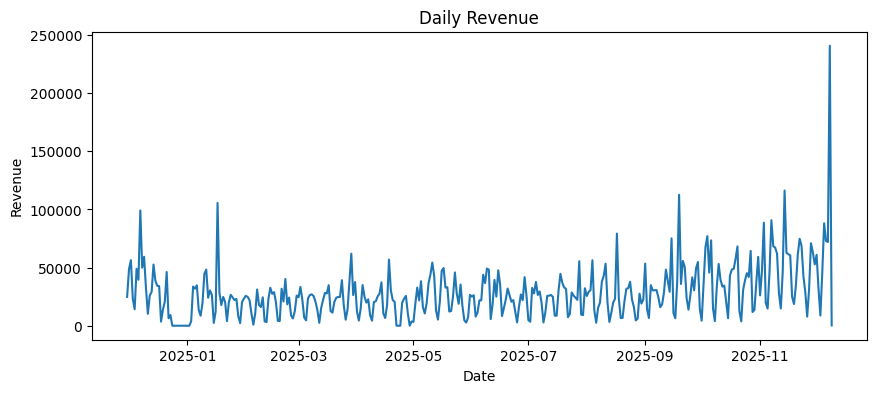

In [7]:
# Daily revenue
daily = df.set_index("InvoiceDate").resample("D")["Revenue"].sum().rename("Revenue").to_frame()

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(daily.index, daily["Revenue"])
ax.set_title("Daily Revenue")
ax.set_xlabel("Date"); ax.set_ylabel("Revenue")
plt.show()


In [9]:
# Top products / customers / countries
top_products = df.groupby("Description", dropna=False)["Revenue"].sum().sort_values(ascending=False).head(10)
top_customers = df.groupby("CustomerID", dropna=False)["Revenue"].sum().sort_values(ascending=False).head(10)
top_countries = df.groupby("Country", dropna=False)["Revenue"].sum().sort_values(ascending=False).head(10)

display(top_products.to_frame("Revenue"))
display(top_customers.to_frame("Revenue"))
display(top_countries.to_frame("Revenue"))


,Revenue
Description,
DOTCOM POSTAGE,"206,248.77"
REGENCY CAKESTAND 3 TIER,"174,156.54"
"PAPER CRAFT , LITTLE BIRDIE","168,469.60"
WHITE HANGING HEART T-LIGHT HOLDER,"106,236.72"
PARTY BUNTING,"99,445.23"
JUMBO BAG RED RETROSPOT,"94,159.81"
MEDIUM CERAMIC TOP STORAGE JAR,"81,700.92"
POSTAGE,"78,101.88"
Manual,"77,752.82"


,Revenue
CustomerID,
NaN,"1,754,901.91"
"14,646.00","280,206.02"
"18,102.00","259,657.30"
"17,450.00","194,390.79"
"16,446.00","168,472.50"
"14,911.00","143,711.17"
"12,415.00","124,914.53"
"14,156.00","117,210.08"
"17,511.00","91,062.38"


,Revenue
Country,
United Kingdom,"9,001,744.09"
Netherlands,"285,446.34"
EIRE,"283,140.52"
Germany,"228,678.40"
France,"209,625.37"
Australia,"138,453.81"
Spain,"61,558.56"
Switzerland,"57,067.60"
Belgium,"41,196.34"


/tmp/ipython-input-4136772091.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = df.set_index("InvoiceDate").resample("H")["Revenue"].sum()


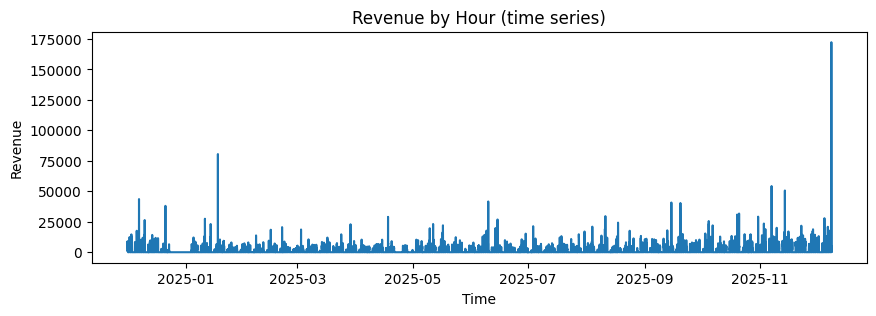

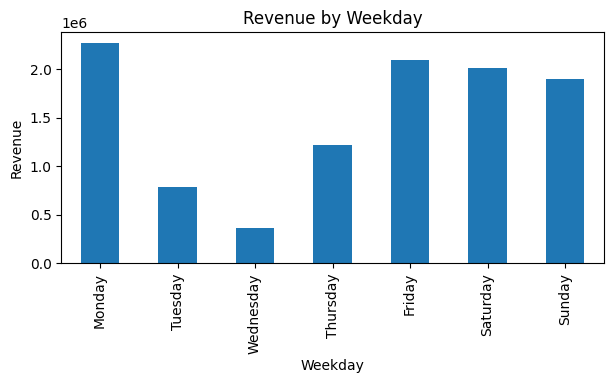

In [10]:
# Hour-of-day and weekday patterns (optional)
df["Hour"] = df["InvoiceDate"].dt.hour
df["Weekday"] = df["InvoiceDate"].dt.day_name()

hourly = df.set_index("InvoiceDate").resample("H")["Revenue"].sum()
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(hourly.index, hourly.values)
ax.set_title("Revenue by Hour (time series)")
ax.set_xlabel("Time"); ax.set_ylabel("Revenue")
plt.show()

weekday_rev = df.groupby("Weekday")["Revenue"].sum().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)
weekday_rev.plot(kind="bar", title="Revenue by Weekday", figsize=(7,3))
plt.ylabel("Revenue"); plt.show()


In [11]:
def rfm_snapshot(dfx: pd.DataFrame, snapshot_date: pd.Timestamp|None=None) -> pd.DataFrame:
    if snapshot_date is None:
        snapshot_date = dfx["InvoiceDate"].max() + pd.Timedelta(days=1)
    rfm = dfx.groupby("CustomerID").agg(
        recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
        frequency=("InvoiceNo", "nunique"),
        monetary=("Revenue", "sum"),
    ).reset_index()
    # Score 1..5 (higher = “better”)
    rfm["R"] = pd.qcut(rfm["recency"].rank(method="first", ascending=False), 5, labels=[1,2,3,4,5]).astype(int)
    rfm["F"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
    rfm["M"] = pd.qcut(rfm["monetary"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
    rfm["RFM_Score"] = rfm["R"] + rfm["F"] + rfm["M"]
    return rfm

if "CustomerID" in df.columns and df["CustomerID"].notna().any():
    rfm = rfm_snapshot(df)
    rfm.sort_values("RFM_Score", ascending=False).head(10)


In [13]:
import os
CLEAN_PATH = "data/online_retail_clean.csv"
os.makedirs("data", exist_ok=True)
df.to_csv(CLEAN_PATH, index=False)
CLEAN_PATH

'data/online_retail_clean.csv'

In [14]:
%%writefile app_sales.py
# -*- coding: utf-8 -*-
"""
Real-Time E-Commerce Sales Dashboard
Flow: EDA → Metrics → Forecasting → Deployment (Streamlit)

- Uses the SAME cleaning/coercion helpers as your notebook:
  load_retail_csv → coerce_schema → clean_transactions → shift_dates_to_recent
- Optional date-shift to 2024–2025 to simulate “real-time”
- Tabs:
  🔎 EDA: KPIs, daily revenue, top products/customers/countries
  📊 Metrics: RFM snapshot & distributions
  📈 Forecasting: Prophet (if available) or ARIMA (pmdarima) with backtest
  🟢 Live Mode: synthetic order stream in current filter context

Author: Your Name
"""

from __future__ import annotations

import os
import time
import numpy as np
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt

# Forecasting (Prophet optional, ARIMA fallback)
try:
    from prophet import Prophet  # pip install prophet
    _HAVE_PROPHET = True
except Exception:
    _HAVE_PROPHET = False

try:
    import pmdarima as pm  # pip install pmdarima
    _HAVE_PM = True
except Exception:
    _HAVE_PM = False


# -----------------------------
# Streamlit Page Config
# -----------------------------
st.set_page_config(page_title="Real-Time E-Commerce Sales Dashboard", layout="wide")
st.title("🛒 Real-Time E-Commerce Sales Dashboard")


# -----------------------------
# Notebook-aligned helpers
# -----------------------------
@st.cache_data(show_spinner=False)
def load_retail_csv(path: str) -> pd.DataFrame:
    """Read Online Retail CSV (latin-1 commonly needed)."""
    return pd.read_csv(path, encoding="latin-1")

def coerce_schema(df: pd.DataFrame) -> pd.DataFrame:
    """Coerce types to sensible dtypes & build Revenue, mirror notebook logic."""
    out = df.copy()
    if "InvoiceDate" in out.columns:
        out["InvoiceDate"] = pd.to_datetime(out["InvoiceDate"], errors="coerce")
    for col in ["Quantity", "UnitPrice", "CustomerID"]:
        if col in out.columns:
            out[col] = pd.to_numeric(out[col], errors="coerce")
    if "Description" in out.columns:
        out["Description"] = (
            out["Description"].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)
        )
    if set(["Quantity", "UnitPrice"]).issubset(out.columns):
        out["Revenue"] = out["Quantity"] * out["UnitPrice"]
    return out

def clean_transactions(df: pd.DataFrame, keep_returns: bool=False) -> pd.DataFrame:
    """
    Clean Online Retail transactions.
    - Drop missing critical fields
    - Remove returns/cancellations unless keep_returns=True
    - Drop zero/negative Revenue
    """
    out = df.copy()
    critical = [c for c in ["InvoiceDate","InvoiceNo","StockCode","Quantity","UnitPrice"] if c in out.columns]
    out = out.dropna(subset=critical)

    if not keep_returns:
        out = out[(out["Quantity"] > 0) & (out["UnitPrice"] > 0)]
        if "InvoiceNo" in out.columns and out["InvoiceNo"].dtype == object:
            out = out[~out["InvoiceNo"].astype(str).str.startswith("C")]

    if "Revenue" in out.columns:
        out = out[out["Revenue"] > 0]

    out = out.drop_duplicates()

    # Derived columns (guard if missing)
    if "InvoiceDate" in out.columns:
        out["OrderDate"] = out["InvoiceDate"].dt.date
    else:
        out["OrderDate"] = pd.NaT

    if "Country" not in out.columns:
        out["Country"] = "Unknown"
    if "Description" not in out.columns:
        out["Description"] = "Unknown"

    return out

def shift_dates_to_recent(df: pd.DataFrame, date_col="InvoiceDate", recent_year=2025) -> pd.DataFrame:
    """
    Shift dates so the max date aligns to a target date in recent_year.
    Preserves relative gaps to make 2010–2012 data look “current”.
    """
    out = df.copy()
    if date_col not in out.columns or out[date_col].isna().all():
        return out
    max_d = out[date_col].max()
    target_max = pd.Timestamp(year=recent_year, month=max(1, max_d.month), day=min(max_d.day, 28))
    out[date_col] = out[date_col] + (target_max - max_d)
    if date_col in out.columns:
        out["OrderDate"] = out[date_col].dt.date
    return out

@st.cache_data(show_spinner=False)
def base_prepare_dataset(path_or_df, simulate_recent: bool=True, keep_returns: bool=False) -> pd.DataFrame:
    """Load (or use uploaded df), coerce schema, clean, optional date shift, add guards."""
    if isinstance(path_or_df, str):
        df = load_retail_csv(path_or_df)
    else:
        df = path_or_df.copy()

    df = coerce_schema(df)
    df = clean_transactions(df, keep_returns=keep_returns)
    if simulate_recent:
        df = shift_dates_to_recent(df, "InvoiceDate", recent_year=pd.Timestamp.now().year)

    # Guards
    if "CustomerID" not in df.columns:
        df["CustomerID"] = pd.NA
    if "Description" not in df.columns:
        df["Description"] = "Unknown"
    if "Country" not in df.columns:
        df["Country"] = "Unknown"

    return df

def filter_df(df: pd.DataFrame, date_range: tuple, countries: list[str] | None, products: list[str] | None) -> pd.DataFrame:
    out = df.copy()
    if date_range:
        start, end = date_range
        out = out[
            (out["InvoiceDate"] >= pd.to_datetime(start)) &
            (out["InvoiceDate"] <= pd.to_datetime(end) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1))
        ]
    if countries:
        out = out[out["Country"].isin(countries)]
    if products:
        out = out[out["Description"].isin(products)]
    return out

def daily_revenue(df: pd.DataFrame) -> pd.DataFrame:
    s = df.set_index("InvoiceDate").resample("D")["Revenue"].sum().rename("Revenue")
    return s.to_frame()

def compute_kpis(df: pd.DataFrame) -> dict:
    orders = df["InvoiceNo"].nunique() if "InvoiceNo" in df.columns else df.groupby(["InvoiceDate","CustomerID","Description"]).ngroup().nunique()
    customers = df["CustomerID"].nunique(dropna=True) if "CustomerID" in df.columns else 0
    revenue = df["Revenue"].sum() if "Revenue" in df.columns else 0.0
    aov = revenue / max(orders, 1)
    items = int(df["Quantity"].sum()) if "Quantity" in df.columns else 0
    return {"revenue": float(revenue), "orders": int(orders), "aov": float(aov), "customers": int(customers), "items": items}

def top_n(df: pd.DataFrame, by: str, n: int=10) -> pd.DataFrame:
    if by == "products":
        grp = df.groupby("Description", dropna=False)["Revenue"].sum().sort_values(ascending=False).head(n)
        return grp.reset_index().rename(columns={"Description":"Product", "Revenue":"Revenue"})
    if by == "customers":
        grp = df.groupby("CustomerID", dropna=False)["Revenue"].sum().sort_values(ascending=False).head(n)
        return grp.reset_index().rename(columns={"CustomerID":"CustomerID", "Revenue":"Revenue"})
    if by == "countries":
        grp = df.groupby("Country", dropna=False)["Revenue"].sum().sort_values(ascending=False).head(n)
        return grp.reset_index().rename(columns={"Country":"Country", "Revenue":"Revenue"})
    return pd.DataFrame()

def compute_rfm(df: pd.DataFrame, snapshot_date: pd.Timestamp | None=None) -> pd.DataFrame:
    if snapshot_date is None:
        snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)
    rfm = df.groupby("CustomerID").agg(
        recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
        frequency=("InvoiceNo", "nunique"),
        monetary=("Revenue", "sum"),
    ).reset_index()
    # Scores 1..5 (higher “better”)
    rfm["R"] = pd.qcut(rfm["recency"].rank(method="first", ascending=False), 5, labels=[1,2,3,4,5]).astype(int)
    rfm["F"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
    rfm["M"] = pd.qcut(rfm["monetary"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
    rfm["RFM_Score"] = rfm["R"] + rfm["F"] + rfm["M"]
    return rfm

def format_money(x: float) -> str:
    return f"${x:,.0f}"


# -----------------------------
# Sidebar: data source & filters
# -----------------------------
st.sidebar.header("⚙️ Controls")

uploaded = st.sidebar.file_uploader("Upload Online Retail CSV", type=["csv"])
default_path = "online_retail.csv"  # optional local fallback
simulate_recent = st.sidebar.checkbox("Shift dates to current year(s)", value=True, help="Makes historical data look like 2024–2025")
keep_returns = st.sidebar.checkbox("Keep returns/cancellations", value=False)

if uploaded is not None:
    try:
        raw_df = pd.read_csv(uploaded, encoding="latin-1")
    except Exception:
        raw_df = pd.read_csv(uploaded)
elif os.path.exists(default_path):
    raw_df = load_retail_csv(default_path)
else:
    st.info("Upload your Online Retail CSV to begin.")
    st.stop()

df_all = base_prepare_dataset(raw_df, simulate_recent=simulate_recent, keep_returns=keep_returns)

# Filters
min_d, max_d = df_all["InvoiceDate"].min(), df_all["InvoiceDate"].max()
st.sidebar.caption(f"Date range in data: {min_d.date()} → {max_d.date()}")

date_range = st.sidebar.date_input("Filter by date", value=(min_d.date(), max_d.date()))
countries_all = sorted(df_all["Country"].dropna().unique().tolist())
products_all = sorted(df_all["Description"].dropna().unique().tolist())

country_sel = st.sidebar.multiselect("Countries", countries_all, default=[])
product_sel = st.sidebar.multiselect("Products (SKUs)", products_all[:30], default=[])

df = filter_df(df_all, date_range, country_sel, product_sel)


# -----------------------------
# Tabs: EDA → Metrics → Forecasting → Live
# -----------------------------
tab_eda, tab_metrics, tab_fc, tab_live = st.tabs(["🔎 EDA", "📊 Metrics", "📈 Forecasting", "🟢 Live Mode"])

# =============================
# 🔎 EDA
# =============================
with tab_eda:
    st.subheader("Exploratory Data Analysis")

    kpis = compute_kpis(df)
    c1, c2, c3, c4 = st.columns(4)
    c1.metric("Revenue", format_money(kpis["revenue"]))
    c2.metric("Orders", f"{kpis['orders']:,}")
    c3.metric("Avg Order Value", format_money(kpis["aov"]))
    c4.metric("Unique Customers", f"{kpis['customers']:,}")

    st.write("#### Daily Revenue")
    daily = daily_revenue(df)
    fig, ax = plt.subplots()
    ax.plot(daily.index, daily["Revenue"])
    ax.set_xlabel("Date"); ax.set_ylabel("Revenue")
    st.pyplot(fig)

    colA, colB, colC = st.columns(3)
    with colA:
        st.write("#### Top Products")
        st.dataframe(top_n(df, "products", 10))
    with colB:
        st.write("#### Top Customers")
        st.dataframe(top_n(df, "customers", 10))
    with colC:
        st.write("#### Top Countries")
        st.dataframe(top_n(df, "countries", 10))

    st.write("#### Raw (sample)")
    st.dataframe(df.head(20))

# =============================
# 📊 Metrics (RFM & distributions)
# =============================
with tab_metrics:
    st.subheader("Customer Metrics")
    if "CustomerID" in df.columns and df["CustomerID"].notna().any():
        rfm = compute_rfm(df)
        st.write("**RFM Snapshot** (higher score = more valuable)")
        st.dataframe(rfm.sort_values("RFM_Score", ascending=False).head(20))

        st.write("#### RFM Distribution")
        r1, r2, r3 = st.columns(3)
        with r1:
            fig, ax = plt.subplots()
            rfm["recency"].plot(kind="hist", bins=20, ax=ax)
            ax.set_title("Recency (days)")
            st.pyplot(fig)
        with r2:
            fig, ax = plt.subplots()
            rfm["frequency"].plot(kind="hist", bins=20, ax=ax)
            ax.set_title("Frequency (orders)")
            st.pyplot(fig)
        with r3:
            fig, ax = plt.subplots()
            rfm["monetary"].plot(kind="hist", bins=20, ax=ax)
            ax.set_title("Monetary ($)")
            st.pyplot(fig)

        st.download_button("Download RFM CSV", rfm.to_csv(index=False), file_name="rfm_snapshot.csv")
    else:
        st.info("CustomerID not available in this dataset—RFM omitted.")

# =============================
# 📈 Forecasting
# =============================
with tab_fc:
    st.subheader("Sales Forecasting")

    model_choice = st.selectbox("Model", ["Prophet (if available)", "ARIMA (auto)"])
    horizon_days = st.slider("Forecast horizon (days)", 7, 90, 30, 1)
    backtest_days = st.slider("Backtest window (days)", 7, 90, 28, 1)

    # Using full cleaned data improves seasonal stability; switch to df for filtered forecasts if desired
    daily_full = daily_revenue(df_all).asfreq("D").fillna(0.0)

    # Backtest split
    cutoff = daily_full.index.max() - pd.Timedelta(days=backtest_days)
    train = daily_full.loc[:cutoff].copy()
    test = daily_full.loc[cutoff + pd.Timedelta(days=1):].copy()

    def evaluate_forecast(y_true, y_pred) -> dict:
        y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
        rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
        mape = float(np.mean(np.where(y_true != 0, np.abs((y_true - y_pred) / y_true), 0.0))) * 100.0
        return {"RMSE": rmse, "MAPE%": mape}

    left, right = st.columns([2, 1])

    if model_choice.startswith("Prophet") and _HAVE_PROPHET:
        tr = train.reset_index().rename(columns={"InvoiceDate": "ds", "Revenue": "y"})
        te = test.reset_index().rename(columns={"InvoiceDate": "ds", "Revenue": "y"})

        m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
        m.fit(tr)

        # Backtest
        future_bt = te[["ds"]]
        fc_bt = m.predict(future_bt)
        yhat_bt = fc_bt["yhat"].values
        metrics_bt = evaluate_forecast(te["y"].values, yhat_bt)

        # Horizon forecast
        future_h = m.make_future_dataframe(periods=horizon_days, freq="D")
        fc = m.predict(future_h)

        with left:
            st.write("#### Prophet Forecast")
            fig, ax = plt.subplots()
            ax.plot(daily_full.index, daily_full["Revenue"], label="Actual")
            ax.plot(fc["ds"], fc["yhat"], label="Forecast")
            ax.fill_between(fc["ds"], fc["yhat_lower"], fc["yhat_upper"], alpha=0.2, label="Confidence")
            ax.legend(); ax.set_xlabel("Date"); ax.set_ylabel("Revenue")
            st.pyplot(fig)

        with right:
            st.write(f"**Backtest (last {backtest_days}d)**")
            st.json({k: round(v, 2) for k, v in metrics_bt.items()})
            st.download_button("Download forecast (CSV)", fc[["ds","yhat","yhat_lower","yhat_upper"]].to_csv(index=False),
                               file_name="forecast_prophet.csv")

    else:
        if not _HAVE_PM:
            st.warning("pmdarima not installed. Add `pmdarima` to requirements or use Prophet.")
        y_train = train["Revenue"].values
        y_test = test["Revenue"].values
        try:
            model = pm.auto_arima(y_train, seasonal=True, m=7, stepwise=True,
                                  suppress_warnings=True, error_action="ignore")
        except Exception:
            model = pm.auto_arima(y_train, seasonal=False, stepwise=True,
                                  suppress_warnings=True, error_action="ignore")

        # Backtest
        n_test = len(y_test)
        y_pred_bt = model.predict(n_periods=n_test)
        metrics_bt = evaluate_forecast(y_test, y_pred_bt)

        # Horizon forecast
        y_fc = model.predict(n_periods=horizon_days)
        idx_fc = pd.date_range(start=daily_full.index.max() + pd.Timedelta(days=1),
                               periods=horizon_days, freq="D")
        fc_df = pd.DataFrame({"InvoiceDate": idx_fc, "yhat": y_fc})

        with left:
            st.write("#### ARIMA Forecast")
            fig, ax = plt.subplots()
            ax.plot(daily_full.index, daily_full["Revenue"], label="Actual")
            ax.plot(fc_df["InvoiceDate"], fc_df["yhat"], label="Forecast")
            ax.legend(); ax.set_xlabel("Date"); ax.set_ylabel("Revenue")
            st.pyplot(fig)

        with right:
            st.write(f"**Backtest (last {backtest_days}d)**")
            st.json({k: round(v, 2) for k, v in metrics_bt.items()})
            st.download_button("Download forecast (CSV)", fc_df.to_csv(index=False), file_name="forecast_arima.csv")

# =============================
# 🟢 Live Mode (simulator)
# =============================
with tab_live:
    st.subheader("Live Mode (optional simulator)")

    # Initialize session state with last 14 days
    if "live_df" not in st.session_state:
        seed_start = df_all["InvoiceDate"].max() - pd.Timedelta(days=14)
        st.session_state.live_df = df_all[df_all["InvoiceDate"] >= seed_start].copy()

    live_on = st.checkbox("Enable simulator", value=False, help="Generate synthetic orders in the current filter context.")
    batch_size = st.slider("Rows per tick", 10, 500, 100, 10)
    tick = st.button("Generate next batch")

    df_ctx = df.copy() if not df.empty else df_all
    if df_ctx.empty:
        st.info("No data under current filters. Loosen filters to start Live Mode.")
    else:
        # Distributions for sampling
        desc_vals = df_ctx["Description"].dropna().values
        price_map = df_ctx.groupby("Description")["UnitPrice"].median().to_dict()
        qty_map = df_ctx.groupby("Description")["Quantity"].median().clip(1, 12).to_dict()
        country_vals = df_ctx["Country"].dropna().values
        cust_vals = df_ctx["CustomerID"].dropna().astype(str).values
        inv_base = int(st.session_state.live_df["InvoiceNo"].nunique()) if "InvoiceNo" in st.session_state.live_df.columns else 100000

        def synth_batch(n: int) -> pd.DataFrame:
            rng = np.random.default_rng()
            now = pd.Timestamp.now()
            recs = []
            for i in range(n):
                prod = rng.choice(desc_vals)
                price = float(price_map.get(prod, max(1.0, rng.normal(12, 4))))
                qty = int(qty_map.get(prod, max(1, int(abs(rng.normal(2.5, 1.5))))))
                country = rng.choice(country_vals)
                cust = rng.choice(cust_vals) if len(cust_vals) else None
                inv = f"{inv_base + i + 1}"
                recs.append({
                    "InvoiceNo": inv,
                    "StockCode": f"SKU-{abs(hash(prod))%99999:05d}",
                    "Description": prod,
                    "Quantity": qty,
                    "InvoiceDate": now - pd.Timedelta(minutes=int(rng.integers(0, 60))),  # last hour
                    "UnitPrice": price,
                    "CustomerID": cust,
                    "Country": country,
                    "Revenue": qty * price,
                    "OrderDate": (now.date()),
                })
            return pd.DataFrame(recs)

        if live_on and tick:
            new_rows = synth_batch(batch_size)
            # Reuse SAME cleaning guarantees if needed (already clean by construction here)
            st.session_state.live_df = pd.concat([st.session_state.live_df, new_rows], ignore_index=True)

        # KPIs (last 24h)
        live_cut = pd.Timestamp.now() - pd.Timedelta(hours=24)
        live_recent = st.session_state.live_df[st.session_state.live_df["InvoiceDate"] >= live_cut].copy()

        k = compute_kpis(live_recent if not live_recent.empty else st.session_state.live_df)
        c1, c2, c3 = st.columns(3)
        c1.metric("Revenue (24h)", format_money(k["revenue"]))
        c2.metric("Orders (24h)", f"{k['orders']:,}")
        c3.metric("AOV (24h)", format_money(k["aov"]))

        st.write("#### Revenue by Minute (last 2h)")
        live_min = (st.session_state.live_df
                    .set_index("InvoiceDate")
                    .last("2H")["Revenue"]
                    .resample("T").sum().fillna(0.0))
        fig, ax = plt.subplots()
        ax.plot(live_min.index, live_min.values)
        ax.set_xlabel("Time"); ax.set_ylabel("Revenue / min")
        st.pyplot(fig)

        st.write("#### Latest synthetic rows")
        st.dataframe(st.session_state.live_df.tail(20))

# -----------------------------
# Footer
# -----------------------------
st.caption("Tip: Toggle 'Shift dates to current year(s)' to demo a recent timeline. Live Mode simulates streaming orders within your current filters.")


Writing app_sales.py


In [20]:


#Start ngrok and print public URL
!pip -q install pyngrok==7.1.6
from pyngrok import ngrok, conf


# IMPORTANT: set your token for THIS session
os.environ["NGROK_TOKEN"] = os.environ.get("NGROK_TOKEN", "").strip() or "PASTE_YOUR_TOKEN_HERE"
if os.environ["NGROK_TOKEN"] == "2tZ6mqHFZ9n2B4HsTOzAPVA3Jnw_6qB1RFncPLxV8kcYUxNcJ" or not os.environ["NGROK_TOKEN"]:
    print("⚠️ Set NGROK_TOKEN above (replace PASTE_YOUR_TOKEN_HERE) and re-run this cell.")
else:
    ngrok.set_auth_token(os.environ["NGROK_TOKEN"])

    # Close any old tunnels
    try:
        for t in ngrok.get_tunnels():
            ngrok.disconnect(t.public_url)
    except Exception:
        pass

    public = ngrok.connect(PORT, "http")
    print("🌐 Public URL:", public.public_url)

print("\n--- Last 40 lines of Streamlit logs ---")
!tail -n 40 /content/streamlit.log


🌐 Public URL: https://19064f39e9f2.ngrok-free.app

--- Last 40 lines of Streamlit logs ---



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.186.44.55:8501

